<a href="https://colab.research.google.com/github/cheul0518/Self-projects/blob/main/Self-projects/GAN/Mnist(draft).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, Dropout, LeakyReLU
from keras.layers import BatchNormalization
#from keras.layers.advanced_activations import LeakyReLU
from keras.utils.vis_utils import plot_model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

HEIGHT = 28
WIDTH = 28
CHANNELS = 1
IMG_SHAPE = (HEIGHT, WIDTH, CHANNELS)

def discriminator():
    """ Create a discriminator
    """
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same', input_shape=IMG_SHAPE))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha = 0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())    
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model


# Effective way to achieve transformation from e.g 100 dimensions to a 28 x 28 dimentions
# 1) Dense layer as the first hidden layer that has enough nodes to represent a low-resolution version of the output image
# 2) Build many parallel filters resulting in different learned features that can be combined together into a final image
def generator(noise_dim):
    """ noise_dim: noise dimension
        Created a generator
    """
    model = Sequential()
    model.add(Dense(128 * int(HEIGHT/4) * int(WIDTH/4), input_dim = noise_dim)) # (HEIGHT/4) x (WIDTH/4) image
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((int(HEIGHT/4), int(WIDTH/4), 128)))    
    model.add(Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')) # Upsample to (HEIGHT/2) x (WIDTH/2)
    # Why even-sized kernel here? Used a kernel size that is a factor of the stride to avoid a checkerboard pattern that can be observed when upsampling
    # Reference: https://distill.pub/2016/deconv-checkerboard/
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')) # Upsame to (HEIGHT) x (WIDTH)
    model.add(LeakyReLU(alpha=0.2))
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same')) # a feature map of 28 x 28. Sigmoid is used to keep every element value to be within [0,1]    
    return model

def gan(gen, dis):
    """ gen: generator model, dis: discriminator model
    """
    dis.trainable = False
    model =Sequential()
    model.add(gen)
    model.add(dis)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
    return model

def load_dataset():
    """ 
    Load MNIST dataset from Keras.datasets and unpack it
    """
    (X_train, _), (_ , _) = mnist.load_data() # X_train, y_train, X_test, y_test
    X_train = (X_train.astype(np.float32))/255 # Convert uint8 to float32 and rescale (0, 1)
    X_train = np.expand_dims(X_train, axis = -1) # Add a dimension for channel
    return X_train    

def generate_samples(dataset, model, noise_dim, n):
    """ dataset: dataset, model: model, noise_dim: noise dimension, n: the number of samples
    Generate n number of samples in noise dimension from dataset and model
    """ 
    # real samples
    i = np.random.randint(0, dataset.shape[0], n)    
    X_real = dataset[i]
    y_real = np.ones((n, 1))
    # fake samples
    #X = np.random.rand(n, noise_dim)
    X_fake = model.predict(np.random.randn(n, noise_dim))
    y_fake = np.zeros((n, 1))
    return X_real, y_real, X_fake, y_fake

def save_plot(examples, epoch, n =10):
    """ 
    """
    for i in range(n * n):
        plt.subplot(n, n, 1+i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    plt.savefig(filename)
    plt.close()

def summary(dataset, gen, dis, epoch, noise_dim, n):
    """ dataset: dataset, gen: generator, dis: discriminator, epoch: epoch, noise_dim: noise dimension, n: # of samples
    """
    X_real, y_real, X_fake, y_fake = generate_samples(dataset, gen, noise_dim, n)
    acc_real = dis.evaluate(X_real, y_real, verbose=0)
    acc_fake = dis.evaluate(X_fake, y_fake, verbose=0)
    print(f'{100 * acc_real}% {100 * acc_fake}%')
    save_plot(X_fake, epoch)
    filename = 'generator_model_%03d.h5' % (epoch + 1)
    gen.save(filename)

def train(dataset, gen, dis, gan, noise_dim, epochs=100, batch_size=256):
    """ dataset: dataset, gen: generator, dis: discriminator, gan: GAN, noise_dim: noise dimension, epochs: # of epochs, batch: batch size
    """
    batch = int(dataset.shape[0] / batch_size)
    half_batch = int(batch_size/2)
    # Add functionality of numpy.random.shuffle (shuffle along the first axis:  concat X,y, shuffle, and split)
    for i in range(epochs):
        for j in range(batch):
            X_real, y_real, X_fake, y_fake = generate_samples(dataset, gen, noise_dim, half_batch)
            X, y = np.vstack((X_real,X_fake)), np.vstack((y_real, y_fake))
            dLoss = dis.train_on_batch(X, y) # update the discriminator weights
            X_gan = np.random.randn(batch_size, noise_dim)
            y_gan = np.ones((batch_size, 1))
            gLoss = gan.train_on_batch(X_gan, y_gan) # update the generator weights via the discriminator's error
            print(f'{i+1} {j+1} {batch} {dLoss:.3f} {gLoss:.3f}')
        if (i+1) % 10 == 0:
            summary(dataset, gen, dis, i, noise_dim, half_batch)

noise_dim = 100
dis = discriminator()
gen = generator(noise_dim)
gan = gan(gen, dis)
dataset = load_dataset()
train(dataset, gen, dis, gan, noise_dim)

Streaming output truncated to the last 5000 lines.
79 155 234 0.698 0.762
79 156 234 0.677 0.705
79 157 234 0.680 0.720
79 158 234 0.678 0.709
79 159 234 0.692 0.769
79 160 234 0.698 0.710
79 161 234 0.689 0.751
79 162 234 0.700 0.727
79 163 234 0.680 0.722
79 164 234 0.682 0.714
79 165 234 0.692 0.753
79 166 234 0.687 0.730
79 167 234 0.688 0.722
79 168 234 0.683 0.728
79 169 234 0.675 0.733
79 170 234 0.690 0.740
79 171 234 0.668 0.747
79 172 234 0.685 0.709
79 173 234 0.687 0.712
79 174 234 0.665 0.713
79 175 234 0.682 0.708
79 176 234 0.679 0.711
79 177 234 0.682 0.771
79 178 234 0.682 0.749
79 179 234 0.691 0.728
79 180 234 0.662 0.728
79 181 234 0.680 0.720
79 182 234 0.679 0.699
79 183 234 0.684 0.716
79 184 234 0.684 0.750
79 185 234 0.680 0.761
79 186 234 0.676 0.715
79 187 234 0.681 0.710
79 188 234 0.685 0.733
79 189 234 0.674 0.732
79 190 234 0.681 0.746
79 191 234 0.687 0.696
79 192 234 0.693 0.740
79 193 234 0.687 0.723
79 194 234 0.677 0.725
79 195 234 0.686 0.739
79 196

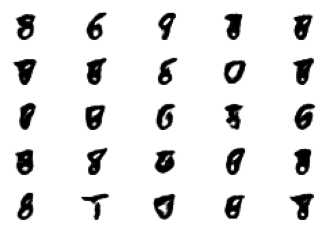

In [16]:
import numpy as np
from keras.models import load_model
from matplotlib import pyplot

def save_plot(examples, n):
    for i in range(n*n):
        plt.subplot(n, n, 1+i)
        plt.axis('off')
        plt.imshow(examples[i, :, :, 0], cmap='gray_r')
    plt.show()

model = load_model('generator_model_090.h5')
noise = np.random.rand(25, 100)
X = model.predict(noise)
save_plot(X, 5)

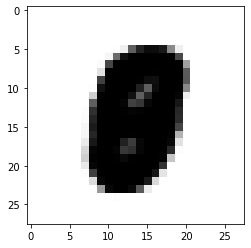

In [17]:
vector = np.asarray([[0.0 for _ in range(100)]])
X = model.predict(vector)
plt.imshow(X[0, :, :, 0], cmap='gray_r')
plt.show()

In [10]:
# def generator():

#     noise_shape = (100,)

#     # Fully connected layers. 
#     model = Sequential()
#     model.add(Dense(256, input_shape=noise_shape))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(1024))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(np.prod(IMG_SHAPE), activation='tanh')) # Making the dense output size 28 * 28 * 1 for reshaping after
#     model.add(Reshape(IMG_SHAPE))
#     model.summary() # Without this code, you cannot see any detailed summary of this model
    
#     noise = Input(shape = noise_shape)
#     img = model(noise)

#     return Model(noise, img)



# def train(epochs, batch_size = 128, interval = 50):
#     (X_train, _), (_ , _) = mnist.load_data() # X_train, y_train, X_test, y_test

#     # Convert uint8 to float32 and rescale (0, 1)
#     X_train = (X_train.astype(np.float32)) / 255

#     # Add a dimension for channel
#     X_train = np.expand_dims(X_train, axis = -1)

#     half_batch = int(batch_size / 2) # half for generator, the other half for discriminator

#     for epoch in range(epochs):
#         # Discriminator
#         i = np.random.randint(0, X_train.shape[0], half_batch) # Returns a ndarray(half_batch, )
#         imgs = X_train[i]

#         noise = np.random.normal(0, 1, (half_batch,100)) # Returns a tuple of (half_batch, 100) size

#         imgs_gen = generator.predict(noise)
#         print(imgs.shape)
        
#         dLoss_real = discriminator.train_on_batch(imgs, np.ones((half_batch,))) # True(1)
#         print(discriminator.train_on_batch(imgs, np.ones((half_batch,))))
#         dLoss_fake = discriminator.train_on_batch(imgs_gen, np.zeros((half_batch,))) # False(0)
#         dLoss = 0.5 * np.add(dLoss_real, dLoss_fake) # Average loss from real and fake images

#         # Generator
#         noise = np.random.normal(0, 1, (batch_size, 100))
#         y_valid = np.array([1] * batch_size)
#         gLoss = combined.train_on_batch(noise, y_valid)

#         # print(f'{epoch} dLoss: {dLoss[0]} accuracy: {100*dLoss[1]:.2f} gLoss: {gLoss}')
#         # if epoch % interval == 0:
#         #     save_imgs(epoch)
#         break

# model = discriminator()
#plot_model(model, to_file='discriminator_plt.png', show_dtype=True, show_shapes=True, show_layer_names=True, show_layer_activations=True)

# optimizer = Adam(0.0002, 0.5)

# discriminator = discriminator()
# discriminator.compile(loss='binary_crossentropy',
#                       optimizer=optimizer,
#                       metrics=['accuracy'])

# generator = generator()
# generator.compile(loss='binary_crossentropy',
#                   optimizer=optimizer)

# z = Input(shape=(100,))
# img = generator(z)

# discriminator.trainable = False
# valid = discriminator(img)
# combined = Model(z, valid)
# combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# train(epochs=50, batch_size=32, interval=10)
